In [ ]:
# Instalar librerías necesarias
!pip install hmmlearn pandas numpy matplotlib scikit-learn openpyxl


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import defaultdict
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


# ========= 1. Cargar datos =========
def cargar_datos(path_excel, sheet_name="S&P500"):
    df = pd.read_excel(path_excel, sheet_name=sheet_name)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date').reset_index(drop=True)
    df = df[['Date', 'Close']].dropna()
    return df


# ========= 2. Crear features =========
def preparar_features(df):
    df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Diff'] = df['Close'].diff()
    df['Return'] = df['Close'].pct_change()
    df['Volatility'] = df['Return'].rolling(window=2).std()
    df = df.dropna().reset_index(drop=True)
    return df


# ========= 3. Escalar datos =========
def escalar_datos(df, features):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df[features])
    return scaled, scaler


# ========= 4. Selección automática de estados =========
def seleccionar_num_estados(data, min_states=2, max_states=8):
    best_model = None
    best_bic = np.inf
    resultados = []

    for n_states in range(min_states, max_states + 1):
        model = GaussianHMM(n_components=n_states, covariance_type="full", n_iter=1000, random_state=42)
        model.fit(data)
        log_likelihood = model.score(data)
        n_features = data.shape[1]
        n_params = n_states**2 + 2 * n_states * n_features - 1
        bic = -2 * log_likelihood + n_params * np.log(len(data))
        aic = -2 * log_likelihood + 2 * n_params
        resultados.append((n_states, bic, aic))

        if bic < best_bic:
            best_bic = bic
            best_model = model

    # Mostrar BIC/AIC
    resultados_df = pd.DataFrame(resultados, columns=["States", "BIC", "AIC"])
    resultados_df.set_index("States").plot(marker='o', figsize=(10, 5))
    plt.title("Selección automática del número de estados (BIC / AIC)")
    plt.ylabel("Valor")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return best_model



# ========= 5. Visualizar estados =========
def plot_estados(df, model, scaled_data):
    hidden_states = model.predict(scaled_data)
    df['State'] = hidden_states

    plt.figure(figsize=(14, 6))
    for i in range(model.n_components):
        state_df = df[df['State'] == i]
        plt.plot(state_df['Date'], state_df['Close'], '.', label=f'Estado {i}')

    plt.title('Estados Ocultos del HMM')
    plt.xlabel('Fecha')
    plt.ylabel('Precio de Cierre')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return df


# ========= 6. Analizar Estados =========
def analizar_modelo(df, model, scaler, feature_names):
    import pandas as pd
    import numpy as np

    print("\n📌 Parámetros del modelo HMM (desescalados):\n")

    descaled_means = scaler.inverse_transform(model.means_)
    scaled_vars = np.array([np.diag(cov) for cov in model.covars_])
    descaled_vars = scaled_vars * (scaler.scale_ ** 2)
    descaled_stds = np.sqrt(descaled_vars)

    all_states_df = []

    for i, (mean, var, std) in enumerate(zip(descaled_means, descaled_vars, descaled_stds)):
        rows = []
        for j, fname in enumerate(feature_names):
            m, v, s = mean[j], var[j], std[j]

            if fname.lower() in ['return', 'volatility', 'log_return']:
                m *= 100
                v *= 100 ** 2
                s *= 100
                rows.append([fname, f"{m:.4f} %", f"{v:.6f}", f"{s:.4f} %"])
            else:
                rows.append([fname, f"{m:.2f}", f"{v:.2f}", f"{s:.2f}"])

        df_estado = pd.DataFrame(rows, columns=["Feature", "Media", "Varianza", "Std"])
        print(f"🟢 Estado {i}")
        print(df_estado.to_string(index=False))
        print("-" * 60)

        # Guardamos para posible exportación
        df_estado.insert(0, 'Estado', i)
        all_states_df.append(df_estado)

    print("\n🔁 Matriz de transición entre estados:")
    print("-" * 60)
    trans_df = pd.DataFrame(model.transmat_,
                            columns=[f"to_{i}" for i in range(model.n_components)],
                            index=[f"from_{i}" for i in range(model.n_components)])
    print(trans_df.round(3))

    print("\n📅 Días representativos por estado (primeros 3):")
    print("-" * 60)
    for i in range(model.n_components):
        fechas = df[df['State'] == i]['Date'].head(3).dt.date.tolist()
        print(f"Estado {i}: {fechas}")

    # Devolver como DataFrame
    return pd.concat(all_states_df, ignore_index=True)



# ========= 7. Guardar resultado =========
def guardar_csv(df, features, filename='SP500_HMM_States.csv'):
    df[['Date'] + features + ['State']].to_csv(filename, index=False)
    print(f"\n📁 Archivo guardado: {filename}")



# ========= 8. Frecuencias y duración de estados =========
def analizar_frecuencia_duracion(df, col_estado='State'):
    print("\n📊 Análisis de frecuencia y duración de los estados ocultos:")
    print("-" * 70)

    estados = df[col_estado].values
    n_estados = df[col_estado].nunique()
    total_dias = len(estados)

    duraciones_por_estado = defaultdict(list)

    actual_state = estados[0]
    duracion_actual = 1

    for i in range(1, len(estados)):
        if estados[i] == actual_state:
            duracion_actual += 1
        else:
            duraciones_por_estado[actual_state].append(duracion_actual)
            actual_state = estados[i]
            duracion_actual = 1
    duraciones_por_estado[actual_state].append(duracion_actual)

    resumen = []

    for estado in sorted(duraciones_por_estado.keys()):
        runs = duraciones_por_estado[estado]
        total = np.sum(runs)
        porcentaje = 100 * total / total_dias
        duracion_media = np.mean(runs)
        duracion_maxima = np.max(runs)
        n_runs = len(runs)

        resumen.append([estado, total, porcentaje, n_runs, duracion_media, duracion_maxima])

    resumen_df = pd.DataFrame(resumen, columns=[
        "Estado", "Frecuencia (días)", "Frecuencia (%)", "Episodios", "Duración media", "Duración máx."
    ])
    resumen_df["Frecuencia (%)"] = resumen_df["Frecuencia (%)"].map(lambda x: f"{x:.2f}%")
    resumen_df["Duración media"] = resumen_df["Duración media"].round(2)
    resumen_df["Duración máx."] = resumen_df["Duración máx."].astype(int)

    print(resumen_df.to_string(index=False))

    # ---------- GRAFICO 1: Frecuencia absoluta ----------
    plt.figure(figsize=(8, 5))
    sns.barplot(data=resumen_df, x="Estado", y="Frecuencia (días)", palette="Set2")
    plt.title("Frecuencia total por estado (días)")
    plt.ylabel("Frecuencia (días)")
    plt.xlabel("Estado")
    plt.tight_layout()
    plt.show()

    # ---------- GRAFICO 2: Duración media por episodio ----------
    plt.figure(figsize=(8, 5))
    sns.barplot(data=resumen_df, x="Estado", y="Duración media", palette="Set3")
    plt.title("Duración media de episodios por estado")
    plt.ylabel("Duración media (días)")
    plt.xlabel("Estado")
    plt.tight_layout()
    plt.show()

    return resumen_df


📊 Buscando el número óptimo de estados ocultos...


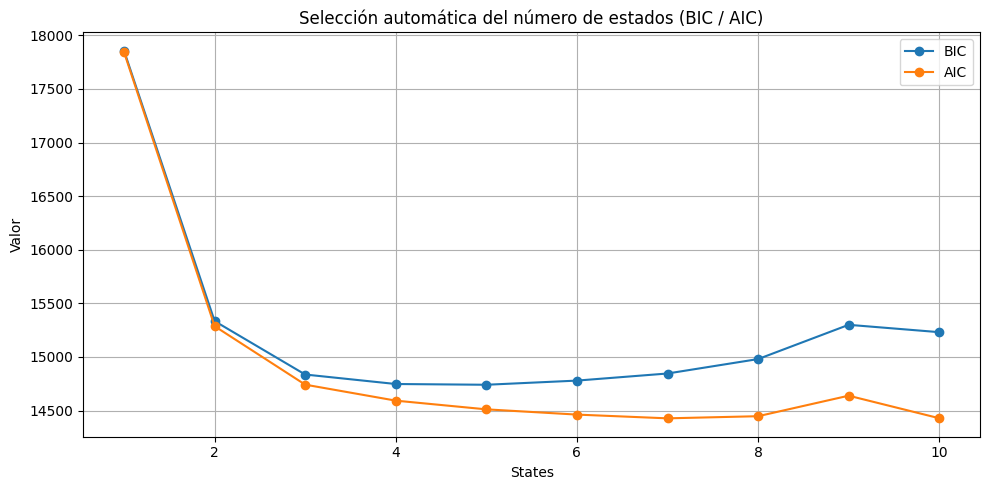

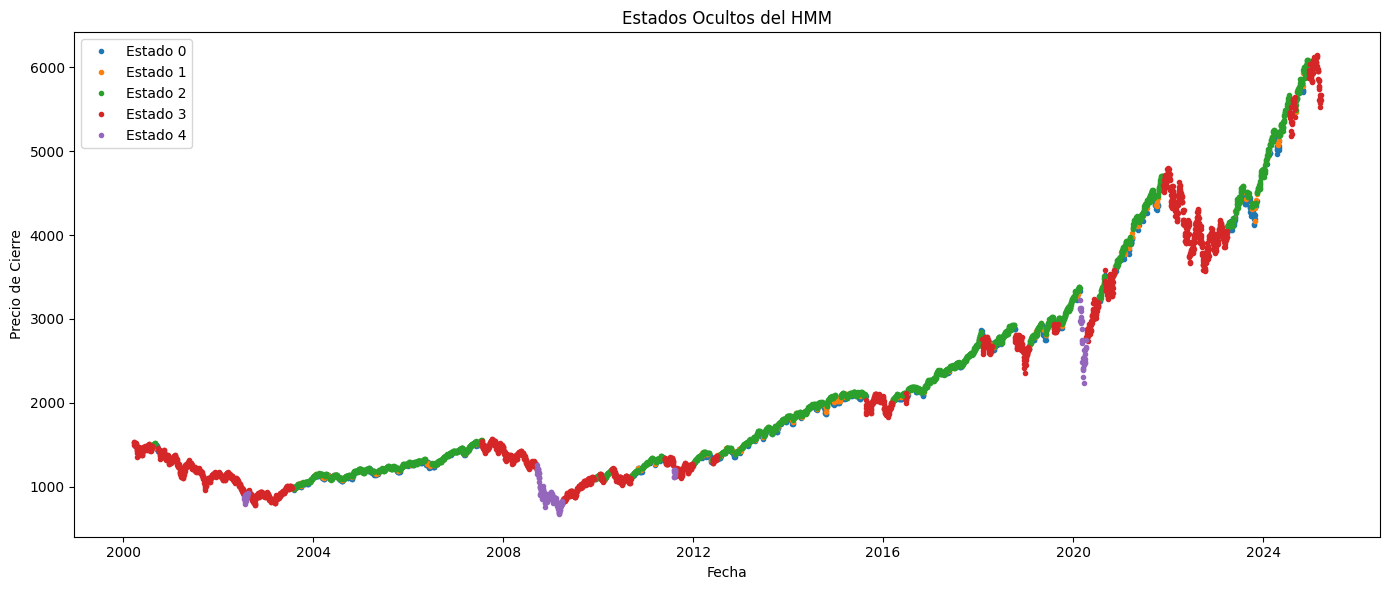


📌 Parámetros del modelo HMM (desescalados):

🟢 Estado 0
Feature     Media Varianza      Std
 Return -0.3098 % 0.622543 0.7890 %
------------------------------------------------------------
🟢 Estado 1
Feature    Media Varianza      Std
 Return 1.0678 % 0.273760 0.5232 %
------------------------------------------------------------
🟢 Estado 2
Feature    Media Varianza      Std
 Return 0.1162 % 0.196698 0.4435 %
------------------------------------------------------------
🟢 Estado 3
Feature     Media Varianza      Std
 Return -0.0532 % 2.291415 1.5137 %
------------------------------------------------------------
🟢 Estado 4
Feature     Media  Varianza      Std
 Return -0.2445 % 14.381251 3.7923 %
------------------------------------------------------------

🔁 Matriz de transición entre estados:
------------------------------------------------------------
         to_0   to_1   to_2   to_3   to_4
from_0  0.709  0.272  0.000  0.017  0.001
from_1  0.501  0.101  0.398  0.000  0.000
from_2  0.

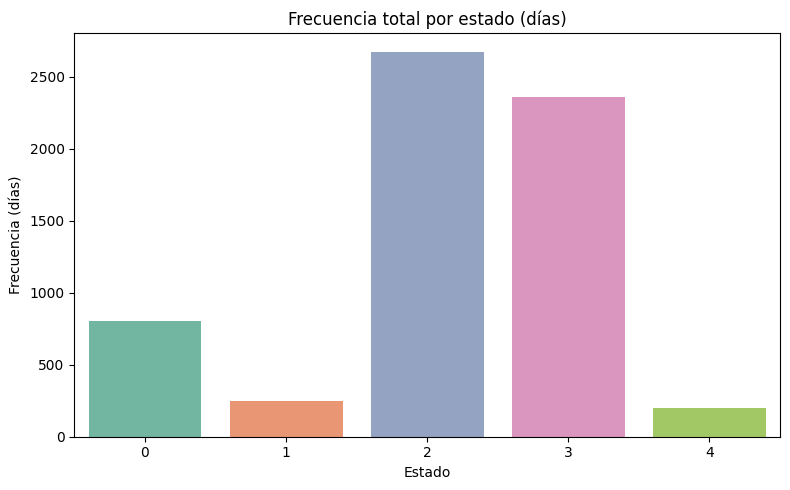

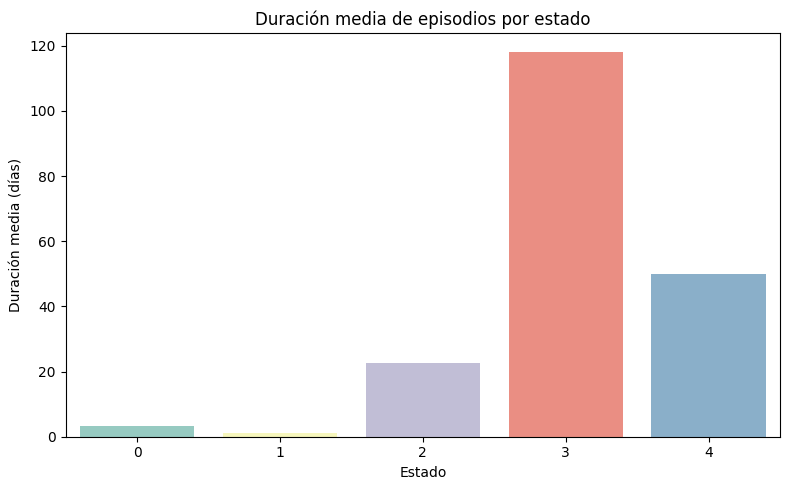

📁 Resumen de frecuencias de estados guardado como HMM_state_frequency.csv


In [ ]:
# ========= 8. Main =========
def main():
    # 1. Cargar y preparar datos
    df = cargar_datos("SP500_datos25y.xlsx")
    df = preparar_features(df)

    # 2. Definir features
    features = ['Return']

    # 3. Escalar
    scaled_data, scaler = escalar_datos(df, features)

    # 4. Entrenar HMM con selección automática de estados
    print("📊 Buscando el número óptimo de estados ocultos...")
    hmm_model = seleccionar_num_estados(scaled_data, min_states=1, max_states=10)

    # 5. Visualizar estados y asignar al DataFrame
    df_resultado = plot_estados(df.copy(), hmm_model, scaled_data)

    # 6. Analizar modelo y obtener resumen como DataFrame
    summary_df = analizar_modelo(df_resultado, hmm_model, scaler, features)

    # 7. Guardar resultados
    guardar_csv(df_resultado, features)

    # 8. Guardar el resumen de los estados
    summary_df.to_csv("HMM_state_summary.csv", index=False)
    print("📁 Resumen de estados guardado como HMM_state_summary.csv")

    # 9. Guardar el resumen de frecuencias de estados
    resumen_df = analizar_frecuencia_duracion(df_resultado)
    resumen_df.to_csv("HMM_state_frequency.csv", index=False)
    print("📁 Resumen de frecuencias de estados guardado como HMM_state_frequency.csv")


if __name__ == "__main__":
    main()
